# Creating a CNN to identify real objects in kbmod data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


## Training Set

Here we are going to use Keras to create a neural network to identify real asteroids from noise in the kbmod results. We have a dataset generated from a kbmod run that contains real objects and false detections. We are going to split it into a training set and a test set and train a neural network to filter between the two.

In [2]:
data = np.genfromtxt('../data/postage_stamp_training.dat')

We will first normalize the data to be between 0.0 and 1.0

In [3]:
for idx in range(len(data)):
    data[idx] -= np.min(data[idx])
    data[idx] /= np.max(data[idx])

First we need to classify the data by eye. 0 will be a false image and 1 will be a true detection. We only show the first of 10 sets of 100 here. To iterate just change the "set_on" parameter.

Starting at 0


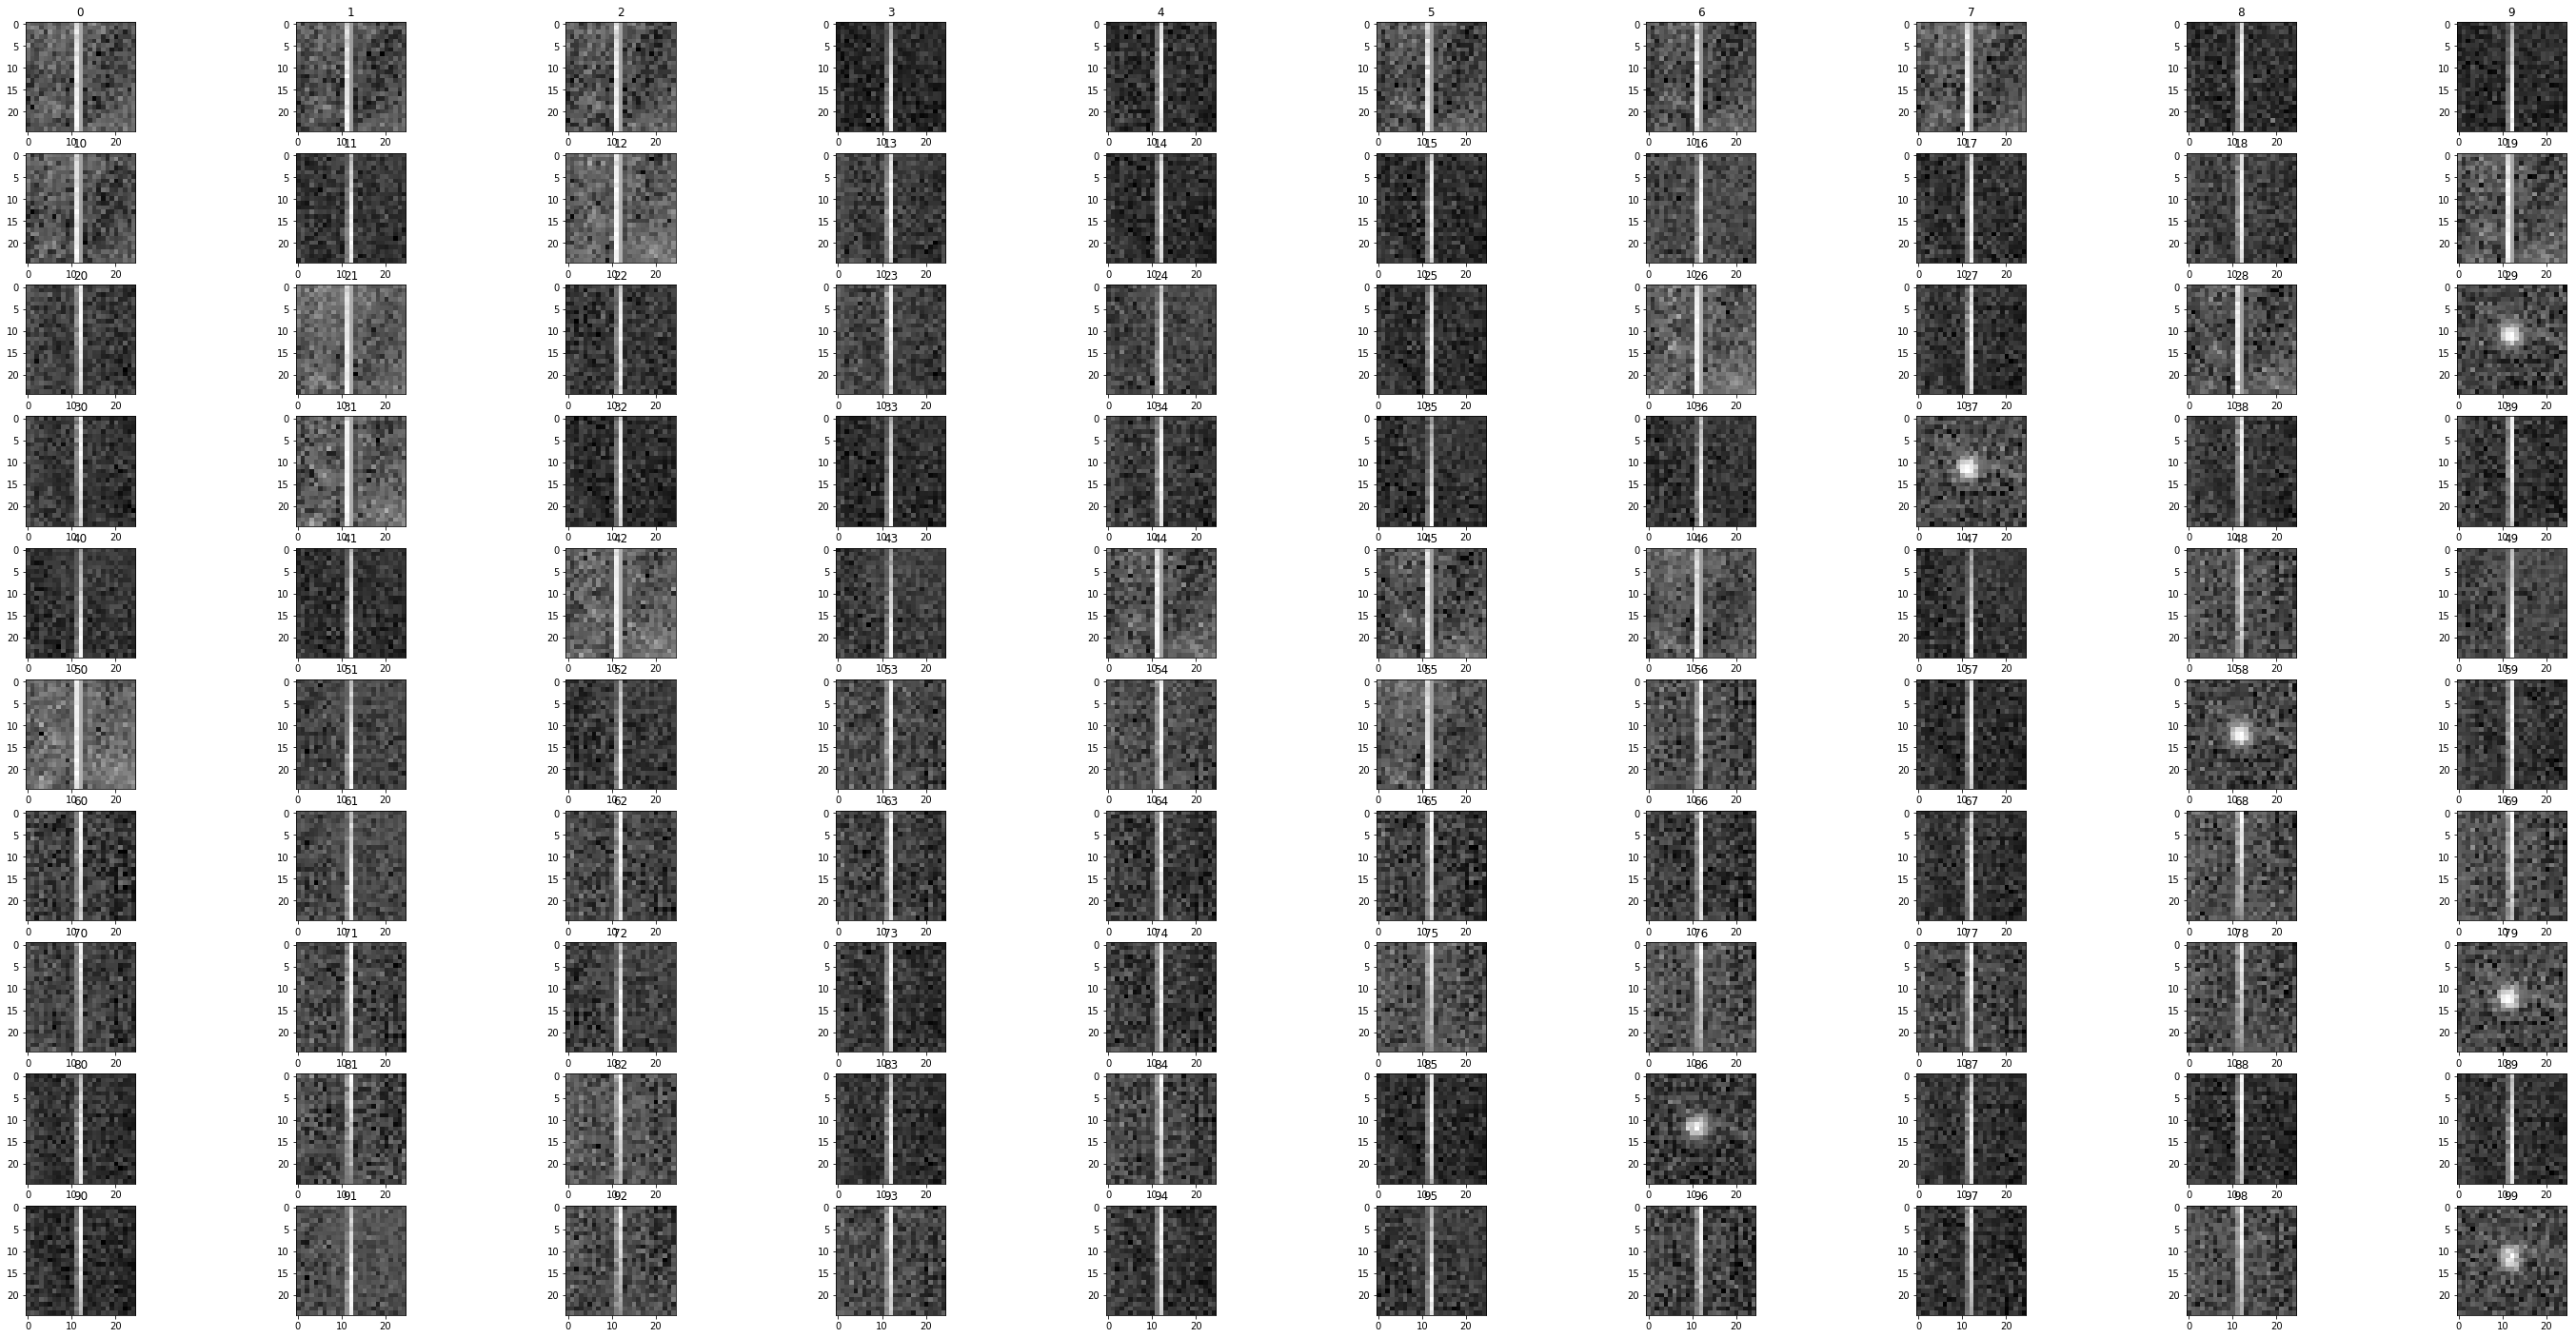

In [4]:
fig = plt.figure(figsize=(50, 25))
set_on = 1
print 'Starting at %i' % int((set_on - 1)*100)
for i in range((set_on-1)*100,set_on*100):
    fig.add_subplot(10,10,i-(set_on-1)*100+1)
    plt.imshow(data[i].reshape(25,25), cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.title(str(i))

In [5]:
classes = np.zeros(1000)

The following are the positive identifications from our training set as classified by eye.

In [6]:
classes[[29, 37, 58, 79, 86, 99, 115, 118, 123, 130, 131, 
         135, 138, 142, 149, 157, 160, 165, 166, 172, 177, 
         227, 262, 347, 369, 393, 
         426, 468, 478, 530, 560, 567, 602, 681]] = 1.

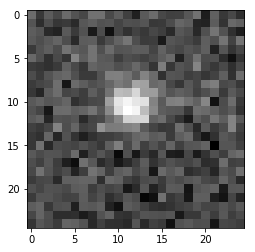

In [7]:
plt.imshow(data[138].reshape(25,25), cmap=plt.cm.Greys_r,
          interpolation=None)

Now we will divide the data into training and test sets (70/30 split).

In [44]:
np.random.seed(42)
assignments = np.random.choice(np.arange(1000), replace=False, size=1000)
train = assignments[:700]
test = assignments[700:]
train_set = data[train]
test_set = data[test]
train_classes = classes[train]
test_classes = classes[test]

## Creating and Training Keras Neural Network

In [45]:
from keras.models import Sequential
from keras.layers import Dense

In [46]:
model = Sequential()

We are currently using a simple neural network model with a 128 unit hidden layer with a sigmoid activation function. The 25 x 25 pixel postage stamps are passed in as a 1-d array for a total of 625 input features. The final output is a binary classification where 1 means a positive identification as an asteroid-like object.

In [47]:
model.add(Dense(128, input_shape=(625,), activation='sigmoid'))
model.add(Dense(1, input_shape=(128,), activation='sigmoid'))

In [48]:
model.output_shape

(None, 1)

The loss function we choose is the binary cross-entropy function.

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

We fit our model and iterate 100 times in the optimization process.

In [50]:
model.fit(train_set, train_classes, batch_size=32, verbose=0, nb_epoch=100)

## Evaluating Results

Once the model is fit we evaluate how it does on the test set and calculate the accuracy. This fit gets to 100% accuracy with our current training data.

In [51]:
score = model.evaluate(test_set, test_classes, verbose=0)
print score, model.metrics_names

[0.00018648342593271158, 1.0] ['loss', 'acc']


Here we take a look at the results with the class predictor and plot one of the positive identifications.

In [52]:
class_results = model.predict_classes(test_set, batch_size=32)

300/300 [==============================] - 0s     


In [38]:
pos_results = np.where(class_results==1.)[0]
print pos_results

[ 16  89 167 239 257 259 261 268 280 283]


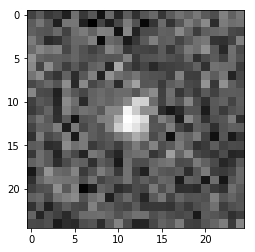

In [28]:
plt.imshow(test_set[pos_results[6]].reshape(25,25), cmap=plt.cm.Greys_r,
          interpolation=None)

## Save Model

Satisfied with our results we save the model to use in real analysis.

In [19]:
model.save('../data/kbmod_model.h5')